In [1]:
import pandas as pd
import os
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from utils.Perspectiver import Perspectiver
from utils.Loader import CardsDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CardsDataset().data.head()

,class index,filepaths,labels
0,18,data/train/jack of hearts/148.jpg,jack of hearts
1,10,data/train/five of hearts/119.jpg,five of hearts
2,9,data/train/five of diamonds/006.jpg,five of diamonds
3,21,data/train/king of clubs/017.jpg,king of clubs
4,39,data/train/six of hearts/049.jpg,six of hearts


In [3]:
scale_1 = 1
scale_2 = 0.60
dataset_scale_100 = CardsDataset(scale=scale_1)
dataset_scale_050 = CardsDataset(scale=scale_2)

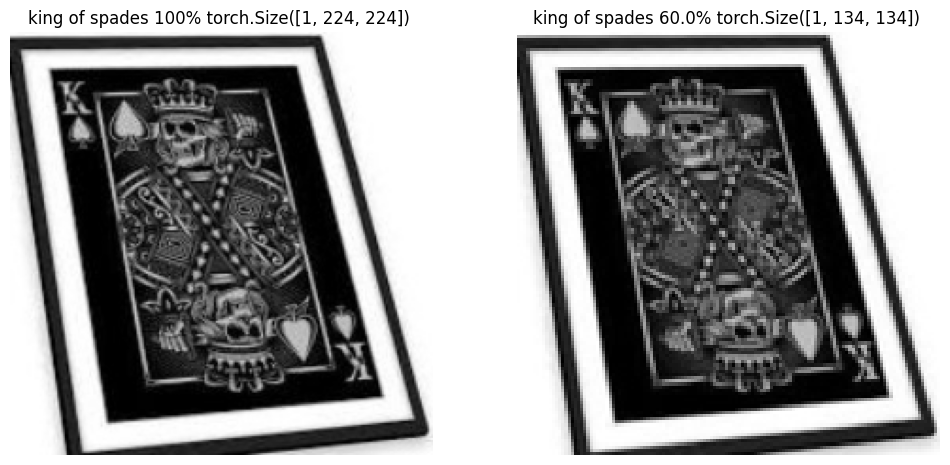

In [4]:
import random
idx = random.randint(0, len(dataset_scale_050))
img_1 , label_1 = dataset_scale_100.__getitem__(idx)
img_2 , label_2 = dataset_scale_050.__getitem__(idx)
Perspectiver.plotComparison(imageBefore = Perspectiver.grayscale_to_rgb(img_1.numpy()[0]) , 
                            imageAfter = Perspectiver.grayscale_to_rgb(img_2.numpy()[0]) , 
                            titleBefore = f"{dataset_scale_100.decode_label(label_1)} {scale_1*100}% {img_1.size()} ",
                            titleAfter = f"{dataset_scale_050.decode_label(label_2)} {scale_2*100}% {img_2.size()} "
                            )

# Pruebita

In [5]:
# Número de clases para la clasificación
num_classes = 52  # Cambia según tu problema

# Cargar MobileNetV3 Large con pesos preentrenados
mobilenet_v3 = models.mobilenet_v3_small(pretrained=True)

# Modificar la primera capa para aceptar imágenes en escala de grises (1 canal en lugar de 3)
mobilenet_v3.features[0][0] = nn.Conv2d(in_channels=1,  # Cambio de 3 (RGB) a 1 (Grayscale)
                                        out_channels=mobilenet_v3.features[0][0].out_channels,
                                        kernel_size=mobilenet_v3.features[0][0].kernel_size,
                                        stride=mobilenet_v3.features[0][0].stride,
                                        padding=mobilenet_v3.features[0][0].padding,
                                        bias=False)

# Reemplazar la última capa de clasificación para el número de clases deseado
mobilenet_v3.classifier[-1] = nn.Linear(in_features=mobilenet_v3.classifier[-1].in_features, out_features=num_classes)

mobilenet_v3.train()

mobilenet_v3 = mobilenet_v3.to(device)

/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
batch_size = 10  # Ajusta según tu GPU
num_epochs = 10

# Instanciar tu dataset
train_dataset = CardsDataset(split="train")  # Suponiendo que tenga un argumento `train=True/False`
val_dataset = CardsDataset(split="valid")

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of diamonds
ace of d

KeyboardInterrupt: 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v3.parameters(), lr=0.001)

In [ ]:
for epoch in range(num_epochs):
    mobilenet_v3.train()  # Modo entrenamiento
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        labels = labels.argmax(dim=1).long()  # Extrae el índice de la clase y lo convierte a `long`

        optimizer.zero_grad()
        outputs = mobilenet_v3(images)
        loss = criterion(outputs, labels)  # Ahora debe funcionar sin errores
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f}")

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/liingfeng/Desktop/repos/CardsRecognition/utils/Loader.py", line 36, in __getitem__
    image = Image.open(img_path).convert(self.convert)
            ^^^^^^^^^^^^^^^^^^^^
  File "/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/PIL/Image.py", line 3469, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/liingfeng/Desktop/repos/CardsRecognition/data/train/ace of clubs/output'
